In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# try:
#     import open_clip
#     from optim_utils import * 
# except ModuleNotFoundError:
#     # You only really need this safety net if you want to run these notebooks directly in the examples directory
#     # Don't worry about this if you installed the package or moved the notebook to the main directory.
#     import os; os.chdir("..")
#     import open_clip
#     from optim_utils import * 
import open_clip
from optim_utils import *
import torchvision

import torch
import mediapy as media
import argparse

/home/eric/miniconda3/envs/control2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
clic = CLIC(root='/home/Shared/image_datasets/CLIC/2021', batch_size=1)

In [3]:
read_json('sample_config.json')

{'prompt_len': 16,
 'iter': 3000,
 'lr': 0.1,
 'weight_decay': 0.1,
 'prompt_bs': 1,
 'loss_weight': 1.0,
 'print_step': 100,
 'batch_size': 1,
 'clip_model': 'ViT-H-14',
 'clip_pretrain': 'laion2b_s32b_b79k'}

## Load Arguments

In [4]:
args = argparse.Namespace()
args.__dict__.update(read_json("sample_config.json"))
args

Namespace(batch_size=1, clip_model='ViT-H-14', clip_pretrain='laion2b_s32b_b79k', iter=3000, loss_weight=1.0, lr=0.1, print_step=100, prompt_bs=1, prompt_len=16, weight_decay=0.1)

## Load Clip Model

In [5]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(args.clip_model, pretrained=args.clip_pretrain, device=device)

## Load Diffusion Model

In [28]:
from diffusers import DPMSolverMultistepScheduler, StableDiffusionPipeline

model_id = "stabilityai/stable-diffusion-2-1-base"
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    revision="fp16",
    )
pipe = pipe.to(device)

image_length = 512

Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 116239.37it/s]


## Load Target Image


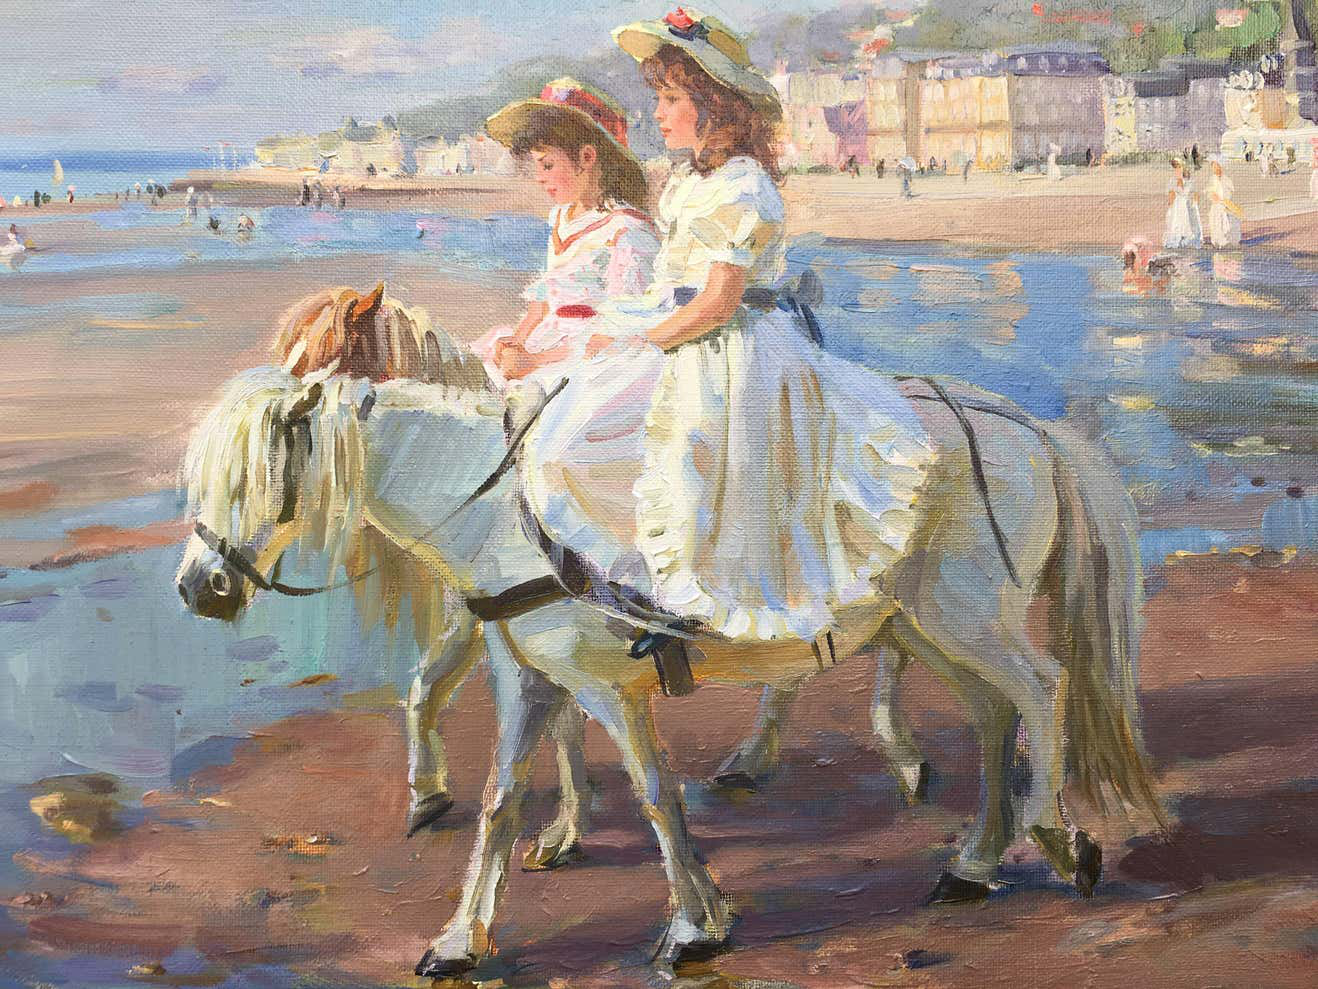

In [7]:
urls = [
        "https://a.1stdibscdn.com/alexander-averin-paintings-pony-riding-on-the-beach-post-impressionist-style-oil-painting-for-sale-picture-6/a_7443/a_28523631526593507117/Promenade_detalle_5_master.JPG?disable=upscale&auto=webp&quality=60&width=1318",
       ]

orig_images = list(filter(None,[download_image(url) for url in urls]))
# x = clic.val_dset[5][0]
# x = torchvision.transforms.functional.to_pil_image(x)
# orig_images = [x]
media.show_images(orig_images)

In [6]:
orig_images

[<PIL.Image.Image image mode=RGB size=1318x989>]

## Optimize Prompt

In [8]:
learned_prompt = optimize_prompt(model, preprocess, args, device, target_images=orig_images)


step: 0, lr: 0.1, cosim: 0.086, text: freapproximately mumford twaledp mclewaz rejeccnnmayoroflennyeducationbuzzfeed stalin 💗💗 

step: 100, lr: 0.1, cosim: 0.344, text: children adverts dorset events vendors flynn tips bbhuttobartholgk 🎨dutt painting myart leighton leighton 

step: 200, lr: 0.1, cosim: 0.347, text: children sall catalina antiques weymouth bookshop tips bbhuttojudith agues sargent som artists warmgw weg

step: 300, lr: 0.1, cosim: 0.410, text: ponies accompanied eastbourne jnr sdcc reception tips bbhuttoalecoscino cgi impressionist ffxv designerdonneinarte r dec 

step: 400, lr: 0.1, cosim: 0.325, text: girls triupier horseracing 🌊 goodwood tips bbhuttohingavoid figures hhh designerdonneinarte r abd 

step: 500, lr: 0.1, cosim: 0.408, text: promenade ponies gigi demonstrate coastal beach recent maywardverstappen signed ymi gw dog 💖💖mcg vg 

step: 600, lr: 0.1, cosim: 0.360, text: girls tabby ponies tig weymouth isonromantic hayward unveils salon dominos sureshpprabhu 

## Generate with Stable Diffusion Model

In [9]:
# you can customize the learned prompt here
prompt = learned_prompt
print(prompt)

childrens strolling ponies vtronda seaside bbhuttomaywardretiring heritage joannebbhuttopcs art preston leighton 


In [11]:
prompt = 'rowland pino percy lovely ponies moment seaside fra'

100%|██████████| 25/25 [00:05<00:00,  4.41it/s]


prompt: rowland pino percy lovely ponies moment seaside fra



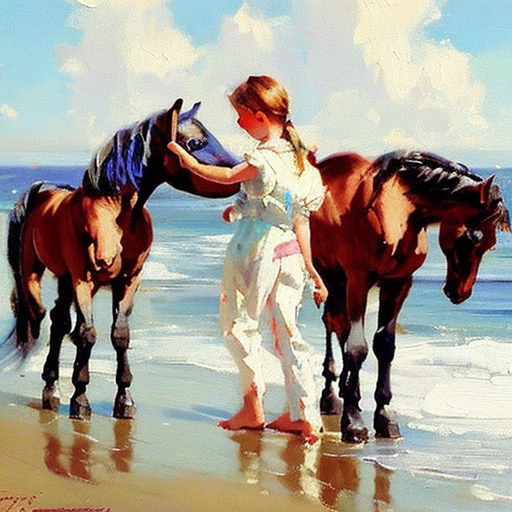
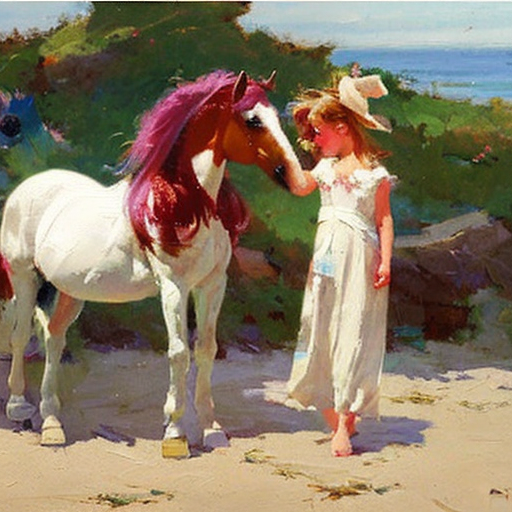
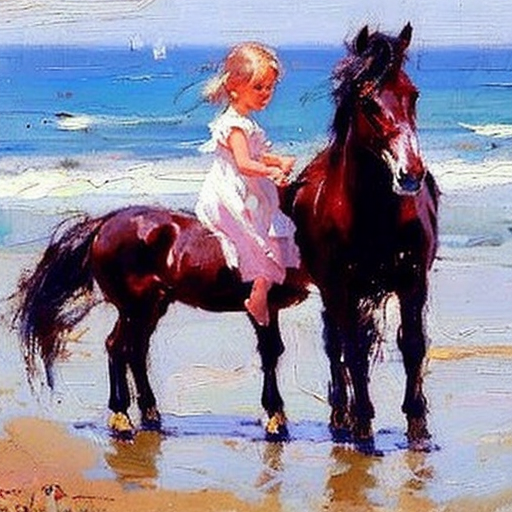
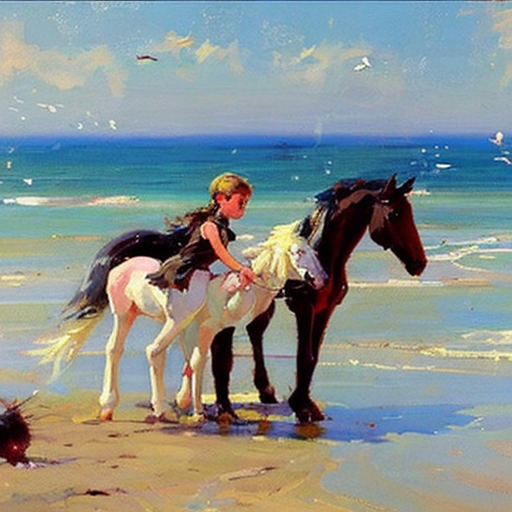

In [41]:
# num_images = 4
# guidance_scale = 12
# num_inference_steps = 25

generator = [torch.Generator(device="cuda").manual_seed(i) for i in range(4)]

images = pipe(
    prompt,
    generator=generator,
    num_images_per_prompt=num_images,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    height=image_length,
    width=image_length,
    # set_random_seed=1234,
    ).images

print(f"prompt: {prompt}")
media.show_images(images)

100%|██████████| 25/25 [00:05<00:00,  4.37it/s]


prompt: rowland pino percy lovely ponies moment seaside fra



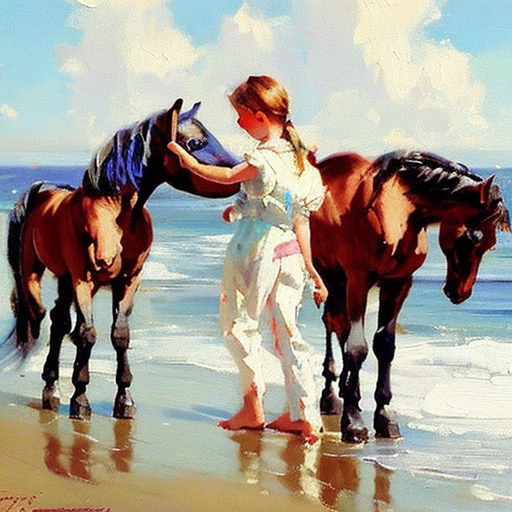
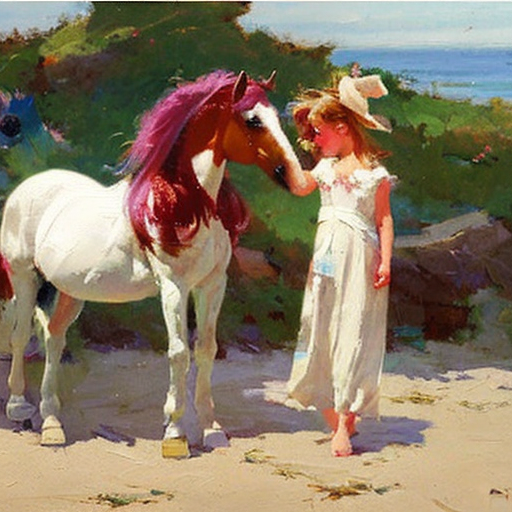
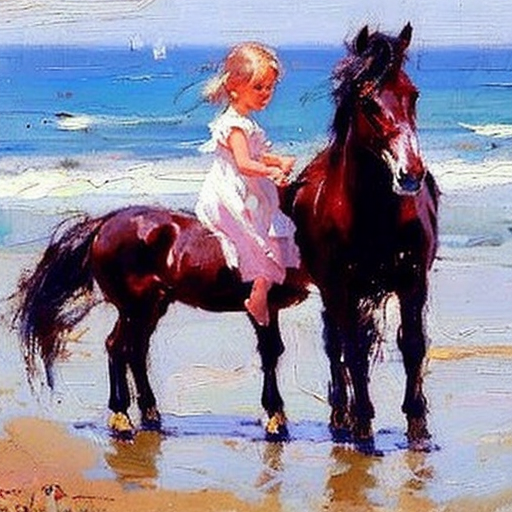
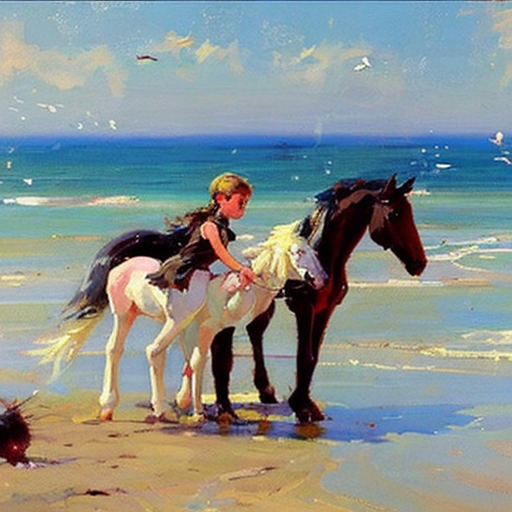

In [44]:
num_images = 4
guidance_scale = 12
num_inference_steps = 25

# generator = [torch.Generator(device="cuda").manual_seed(i) for i in range(4)]

images = pipe(
    prompt,
    generator=[torch.Generator(device="cuda").manual_seed(i) for i in range(num_images)],
    num_images_per_prompt=num_images,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    height=image_length,
    width=image_length,
    # set_random_seed=1234,
    ).images

print(f"prompt: {prompt}")
media.show_images(images)

In [14]:
images

[<PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>]

In [20]:
images[0].size

(512, 512)

In [26]:
np.stack([np.asarray(im) for im in images], axis=0).shape

(4, 512, 512, 3)